# EDA Чекпоинт №2

В данном чекпоинте были проведены анализ исходных данных для обучения компонентов агента, реализованы инструменты для анализа их метрик, а также сбор и анализ онлайн-метрик при работе агента STEVE-1.

## Анализ литературы

Для того, чтобы иметь представление о текущем состоянии той области, в которой мы проводим исследования, а также для эффективного использования техник и инструментов для реализации итогового проекта, необходимо было провести детальный анализ литературы, связанный как с агентом STEVE-1, так и с Minecraft в целом, а также со смежными темами, такими как RL, память моделей, и прочее. В результате наибольший интерес к группе привлекли работы, о которых тезисно написано далее.

> Mamba: Linear-Time Sequence Modeling with Selective State Spaces (Gu & Dao, 2023)

Эта работа представляет архитектуру Selective State Space Model (SSM), которая масштабируется линейно по длине последовательности. Она проявляет интерес тем, что позволяет агенту обрабатывать непрерывный видеопоток геймплея Minecraft с теоретически бесконечным контекстом и без проблем, свойственных трансформерам при длинных временных зависимостях.

> Mastering Diverse Domains through World Models (DreamerV3) (Hafner et al., 2023)

Работа доказывает, что агент может обучаться планировать и действовать, моделируя мир в латентном пространстве без прямого взаимодействия с окружением (environment). Для Minecraft-агента это ключ к созданию так называемого "воображения", он сможет прогнозировать будущие состояния и выбирать действия без проб и ошибок, ускоряя обучение и делая политику намного устойчивее.

> Voyager: An Open-Ended Embodied Agent with Large Language Models (Wang et al., 2023)

Voyager использует LLM не для прямого управления агентом, а для генерации целей и учебных задач на основе текущего состояния мира. Работа полезна для стратегического уровня, а именно LLM может формировать миссии, например, "построй убежище", а не микрокоманды, обеспечивая агенту смысловую направленность, мысленный вектор.

> ELMUR: External Layer Memory with Update/Rewrite for Long-Horizon RL (2025)

Проект вводит механизм внешней долговременной памяти, куда агент может записывать и откуда может извлекать информацию о прошлых событиях. В теории это позволит обеспечит долгосрочное поведение агента. Хранение знаний о ранее исследованных зонах, ресурсах позволяет не тратить время на повторное исследование территории.

> Energy-Based Behavioral Cloning (Florence et al, 2021)

Данная работа примечательна тем, что заменяет вероятностное клонирование поведения на энергетическое, заставляя модель самой ранжировать действия по качеству. В качестве преимуществ можно рассмотреть естественную регуляцию поведения системой, находя наиболее "энергоэффективные" паттерны.

Описанные выше работы в дальнейшем могут быть использованы в качестве источника для экспериментов и улучшения работы агента. Подходы и техники, применяемые для реализации агентов помогают улучшать поведение при тех или иных обстоятельствах, или в различных технических контекстах.

## Анализ данных

Агент STEVE-1 представляет из себя решение композиции двух других проектов, связанных с Minecraft:
* MineCLIP, раздел проекта MineDOJO. Авторы вдохновлялись работой от OpenAI под названием CLIP.
* VPT, огромная video-to-behavior модель от OpenAI, которая может самостоятельно выполнять действия в Minecraft, предсказывая следующие действия.

VPT обучался на 70,000 часов геймплея Minecraft в формате видео, из них 2000 часов были предварительно размечены.

MineDOJO в качестве обучающего датасета использовал 730,000 видео общей длиной в 33 года. Из них 640,000 пар видео-промпт были задействованы в обучении MineCLIP.

STEVE-1, в свою очередь, взаимствовал ~540 часов геймплея у датасета VPT и ~210 часов были сгенерированы в процессе посредством обучения без учителя. А также было использовано ~2000 пар видео-промпт.

Нетрудно заметить, что практически все данные, используемые для данного проекта, являются видеороликами, причем в огромных масштабах. Проанализировать подобного размера кластеры комплексных данных за срок, предоставленный на данный чекпоинт, не представляется возможным.

По этой причине было предпринято сменить фокус анализа с исходных данных на производные от самой модели. Таким образом, было необходимо проанализировать работу компонент по отдельности, чтобы определить их слабые стороны, а также непосредственно агента для определения метрик готового продукта.

## Анализ компонентов агента

В качестве связывающих проекты компонентов выступают так называемые Prior и Policy.

Prior является простым CVAE, задача которого предсказывать визуальные эмбеддинги по исходному промпту от человека. При помощи MineCLIP Prior переводит текст промпта в текстовый эмбеддинг и прогоняет его через свою CVAE модель, пытаясь сопоставить промпт с недостающим видеороликом, демонстрирующий задачу.

Для проверки "надежности" данного компонента было необходимо определить: насколько точно совпадают предсказанные и настоящие эмбеддинги видео, или насколько сильно они корреллируют.

Чтобы определить, насколько два эмбеддинга коррелируют между собой, или смотрят ли два вектора в одну сторону, была использована метрика косинусного сходства: $$\cos(\theta)=\frac{A*B}{||A||\space||B||}$$, где $A,B$ - два эмбеддинга в виде векторов. Метрика варьируется от -1 до 1, где -1 означает отрицательную корелляцию, 0 - отсутствие сходства, а 1 - идеальное сходство.

Также для проверки полного соответствия нужно было проверить попарно координаты векторов, что ведет нас к использованию MSE. Это нам покажет, как сильно различаются точки эмбеддингов в латентном пространстве.

И в конце хотелось проверить, а насколько действительно Prior способен "угадывать тот самый эмбеддинг". Было решено использовать Recall@k, где модель генерирует набор эмбеддингов и для каждого вычисляется косинусное сходство с оригинальным визуальным эмбеддингом. Если среди k самых похожих эмбеддингов будет попарный с оригиналом, то считаем, что модель справилась. И так получим отношение успешных генераций на все.

Для тестирования Prior был использован датасет, который содержит 50 тысяч пар визуального и текстового эмбеддингов. Таким образом, текстовое пространство можно перевести в визуальное и сопоставить его в паре.

По результатам замера метрик были получены следующие значения для Prior:

```
num_samples = 53591
cosine_mean = 0.9843205213546753
cosine_std = 0.014285475015640259
mse_mean = 0.029748806729912758
recall@1 = 0.05435614287853241
recall@5 = 0.11074621230363846
recall@10 = 0.15797428786754608
recall@100 = 0.5114851593971252
time_performed_s = 1.67
```

Prior способен обработать 50 тысяч текстовых запросов за примерно 2 секунды, получая почти идентичное сходство по направлению векторов. В среднем модель ошибается примерно на $\sqrt{0.28}=0.53$ по каждой координате вектора.

In [ ]:
text_embeds.max(), text_embeds.min(), visual_embeds.max(), visual_embeds.min()

(tensor(21.), tensor(-4.8086), tensor(19.9888), tensor(-4.1089))

$0.53/24.1=2.2\%$ составляет среднее отклонение от настоящего эмбеддинга по каждому признаку.

В среднем, модель правильно угадывает эмбеддинг в 5% случаев. При этом в топ-5 уже войдет с вероятностью 11%. В топ-10 - 15%, и топ-100 - 51%.

## Сбор данных и анализ агента STEVE-1

Изначальное ограничение в исследовании и анализе исходных материалов привлекло необходимость альтернативного анализа проекта, чтобы искать потенциальные моменты для улучшения проекта. Было решено формировать датасет для EDA при помощи самого агента, а именно его поведения.

Как в своих статьях упоминали авторы VPT и MineCLIP, объем данных, на которых проходило обучение, является довольно огромных, что может говорить о потенциально богатом запасе знаний в самих моделях. По этой причине было предположено, что при таком количестве информации, заложенных в моделях, агенту STEVE-1 достаточно грамотно реализовать эти два инструмента, чтобы получить хорошие итоговые результаты. Из этого был сделан вывод, что для нахождения главных источников интереса для проекта необходимо рассмотреть, как агент распоряжается теми данными, и теми моделями, которые он использует.

### Сбор метрик

В качестве метрик для сбора было решено использовать следующие:

* run_id, id забега
* tick, текущий тик забега
* prompt_id, id текстового запроса
* cos_sim, косинусное сходство последних кадров агента и целевого визуального эмбеддинга из Prior, полученного по промпту
* mse, MSE последних кадров агента и целевого эмбеддинга
* log_prob/mean, средяя вероятность по действиям
* vpred/mean, средний прогноз вероятностей
* buttons/entropy_(cond/uncond/final), энтропия распределения нажатий на кнопки (с целевым эмбеддингом/без него/итоговая сумма логитов)
* buttons/pmax_(cond/uncond/final), максимальная вероятность нажатия кнопок (с целевым эмбеддингом/без него/итоговая сумма логитов)
* buttons/kl_(cond/final)_uncond, KL-дивергенция между распределениями по кнопкам
* guidance/delta_entropy_buttons, разница энтропий нажатий между итоговым и условным
* guidance/ratio_kl_buttons, KL(final | uncond) / KL(cond | uncond)
* camera/entropy_(cond/uncond/final), энтропия по положению камеры
* camera/entropy_(cond/uncond/final)_norm, нормированная энтропия по положению камеры
* camera/pmax_(cond/uncond/final), максимальная вероятность поворота камеры (с целевым эмбеддингом/без него/итоговая сумма логитов)
* camera/kl_(cond/final)_uncond, KL-дивергенция между положением камеры
* guidance/delta_entropy_camera, разница энтропий поворота между итоговым и условным
* guidance/ratio_kl_camera, KL(final | uncond) / KL(cond | uncond)
* life, текущеее количество жизней агента
* food, текущий голод
* x/y/z, координаты агента
* pitch/yaw, положение камеры агента
* distance(_xz), пройденная дистанция агентов с начала забега (_xz, исключая прыжки и падения)
* air, количество доступного воздуха
* seed, seed генерации мира при забеге
* cfg_gamma, условный коэффициент для целевого эмбеддинга (насколько он важнее текущих кадров)
* data, прочая информация (инвентарь, крафт, подбирание предметов, и т.д.)
* attack, зажата ли левая кнопка мыши
* back/forward, идет ли агент назад/вперед
* jump, прыгает ли агент
* left/right, идет ли агент налево/направо
* sneak/sprint, крадется/бежит ли агент
* use/drop, использует/бросает ли агент предмет
* inventory, общее количество предметов в инвентаре
* hotbar.1-9, используется ли ячейка 1-9 в hotbar агента

### EDA поведения агента

Ниже представлены результаты прогона агента со следующими параметрами:

| Task Prompt                   | Ticks | CFG Scale |
|------------------------------------|---------|----|
| chop down trees                    | 1000    | 6  |
| get wood                           | 1000    | 7  |
| collect logs, chop trees           | 1000    | 8  |
| chop down trees to collect wood    | 1000    | 9  |


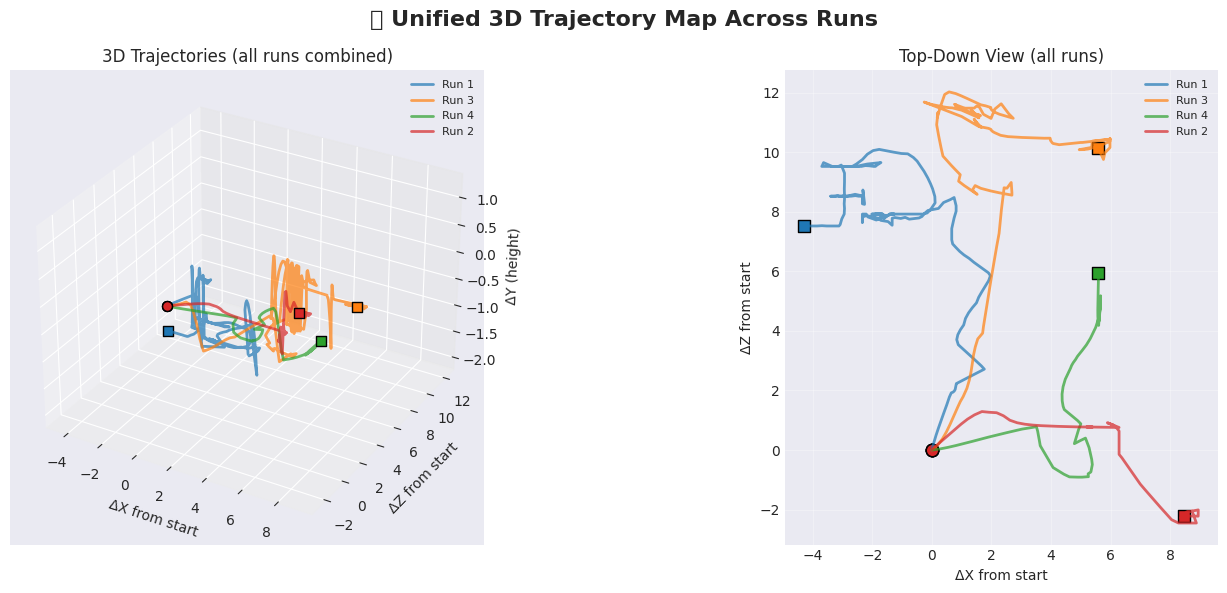

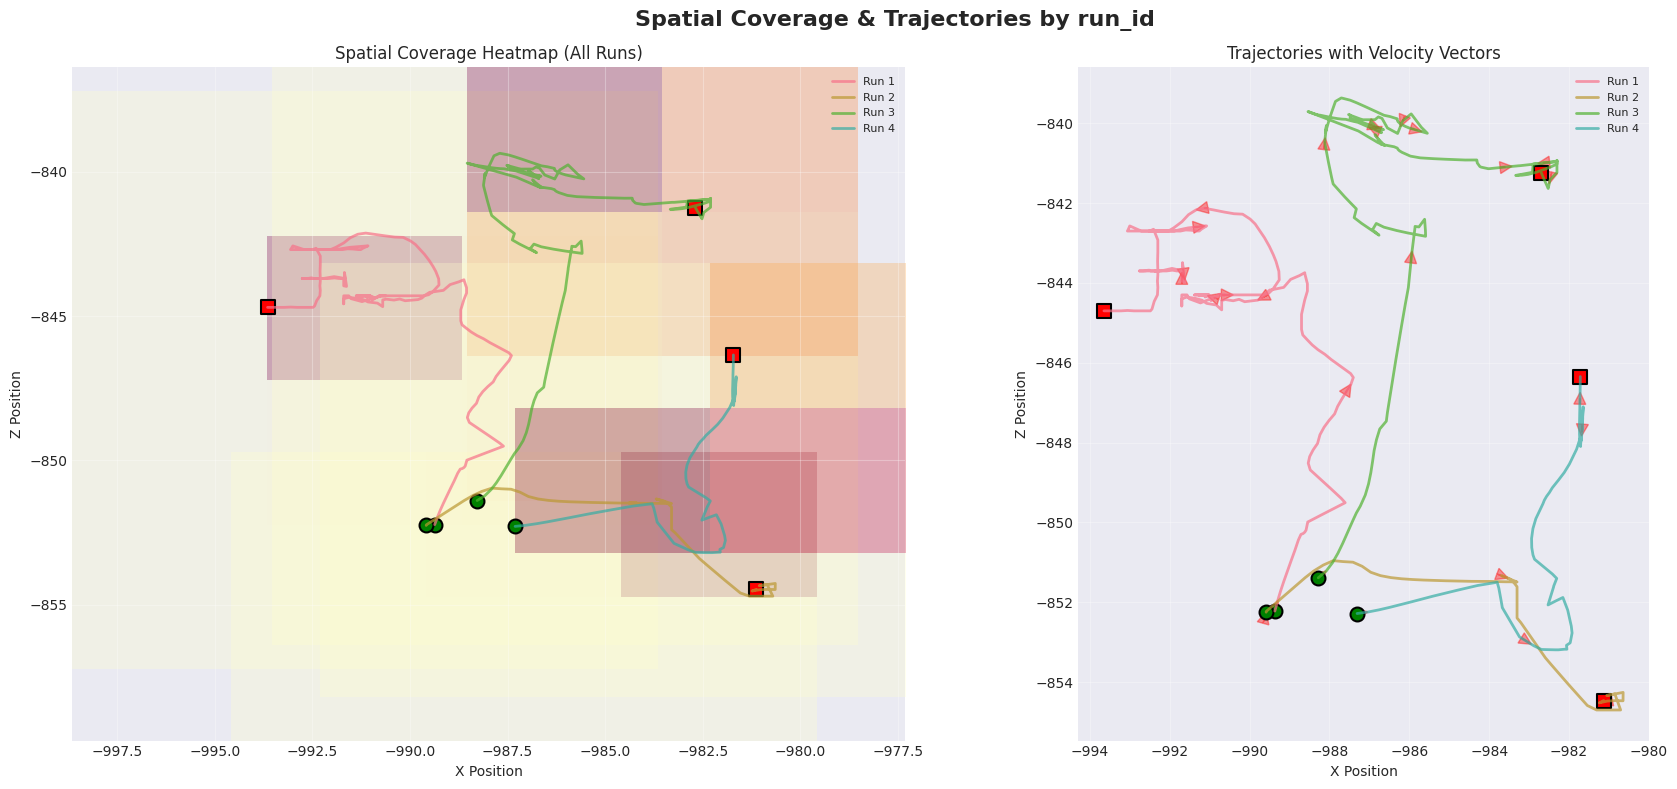

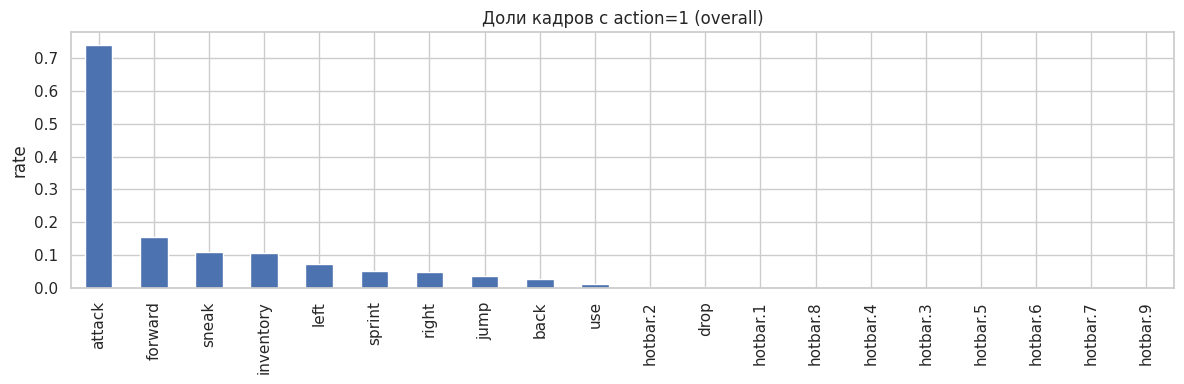

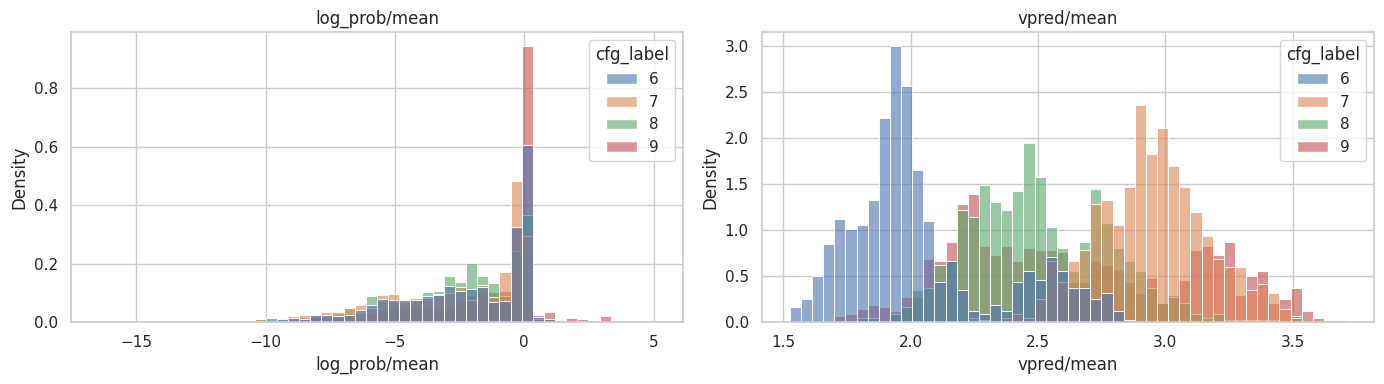

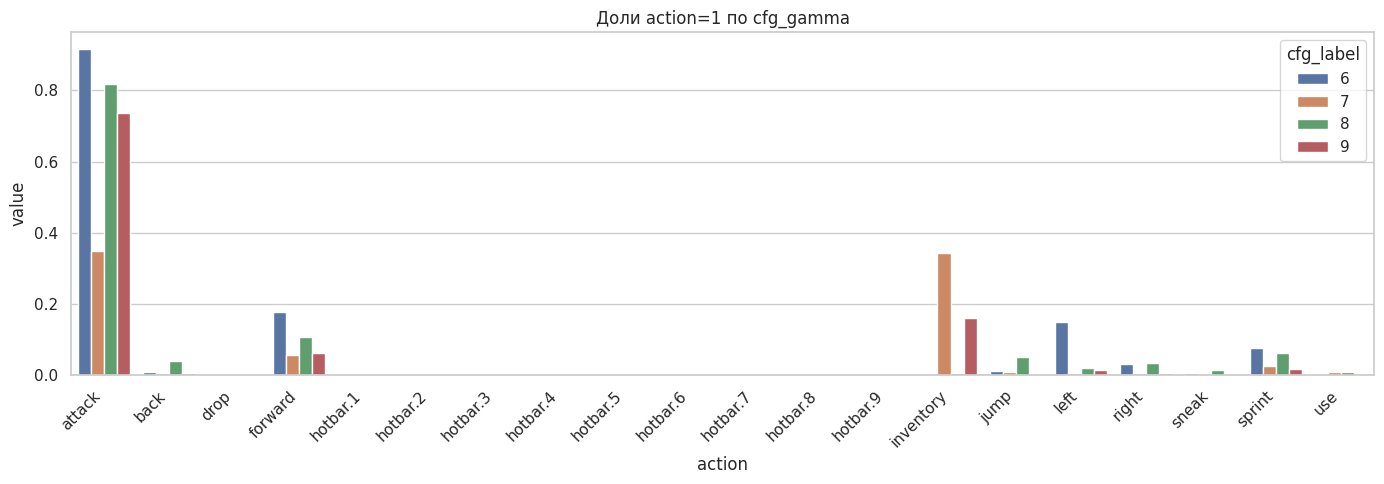

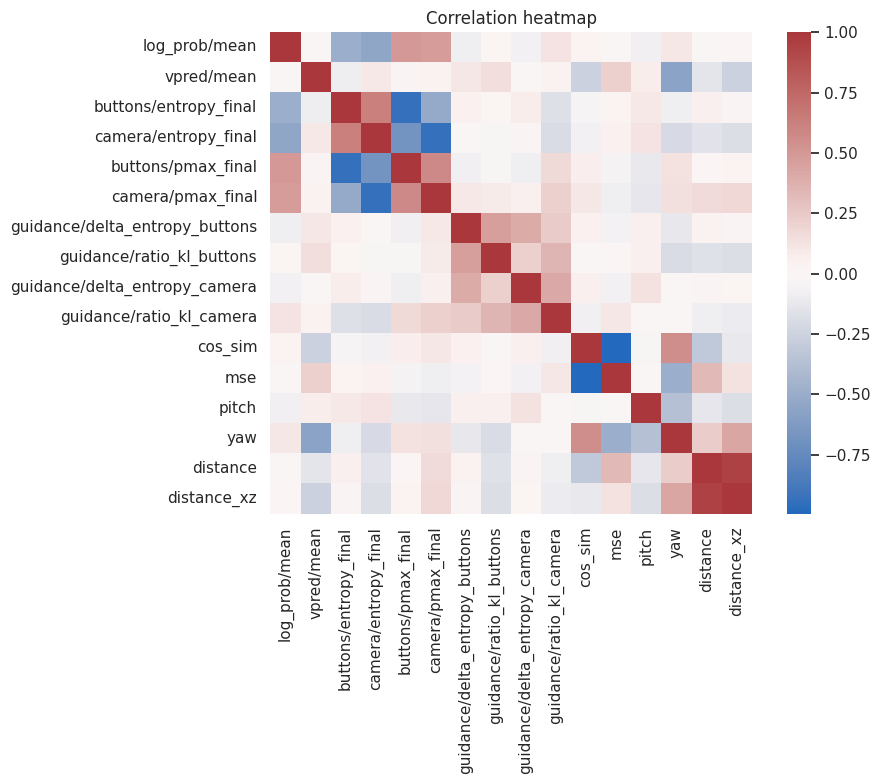

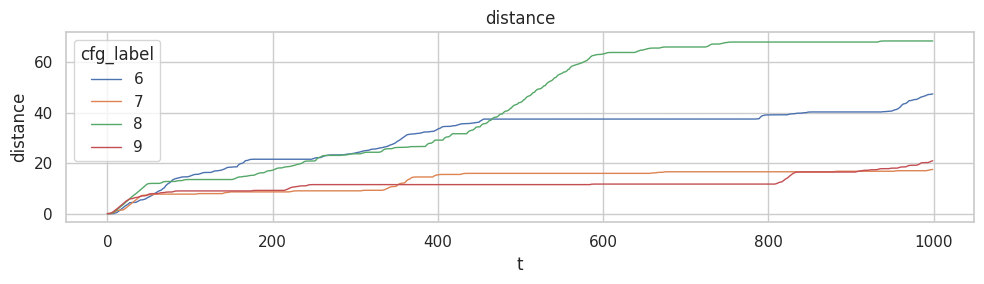

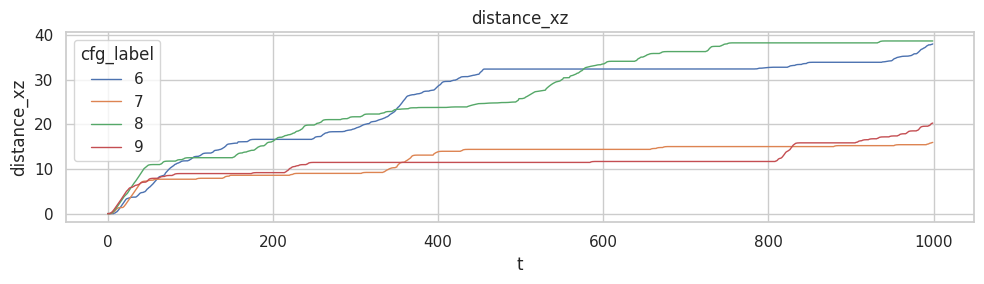

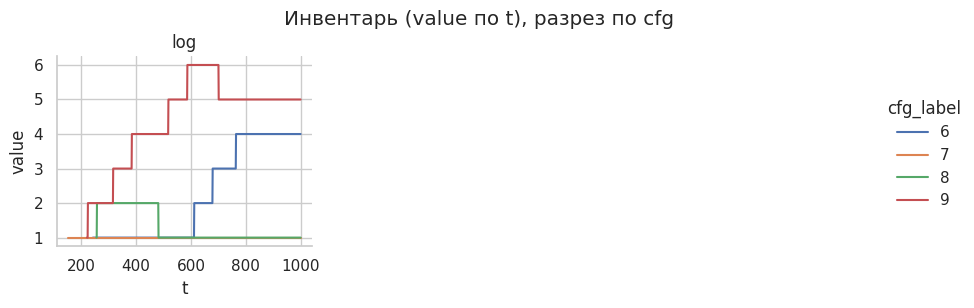

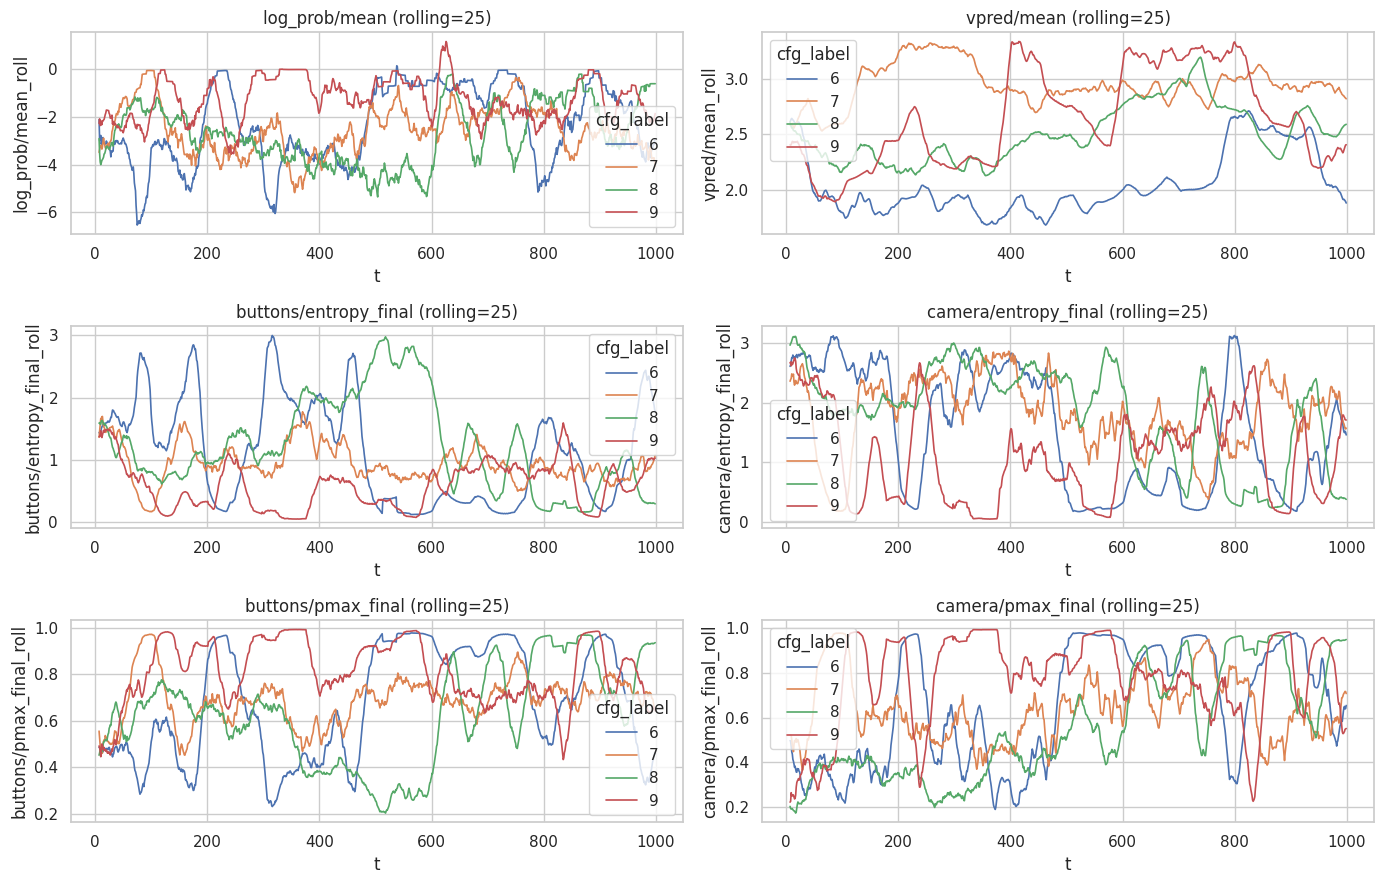

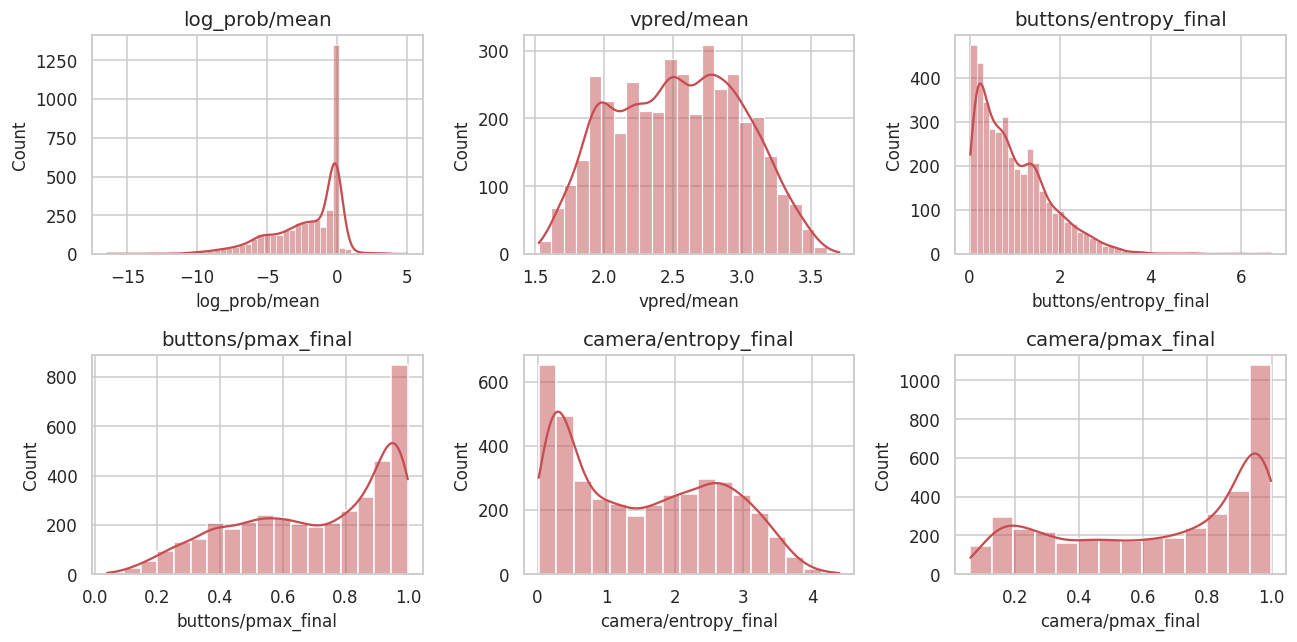

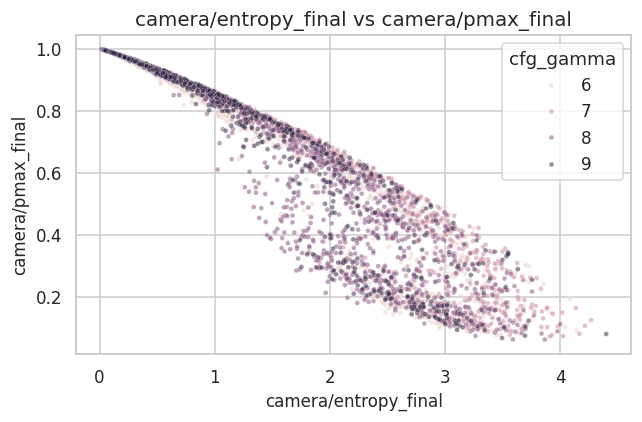

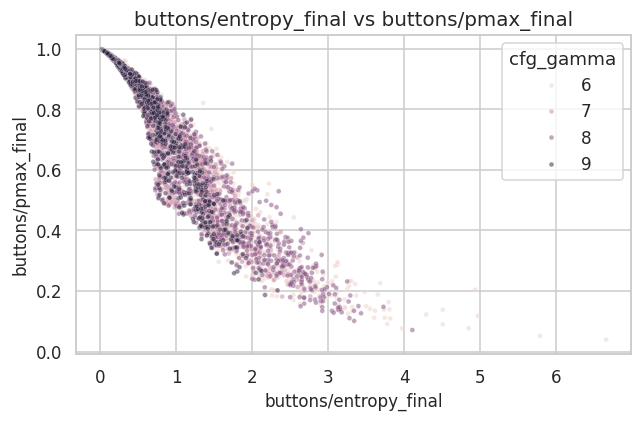

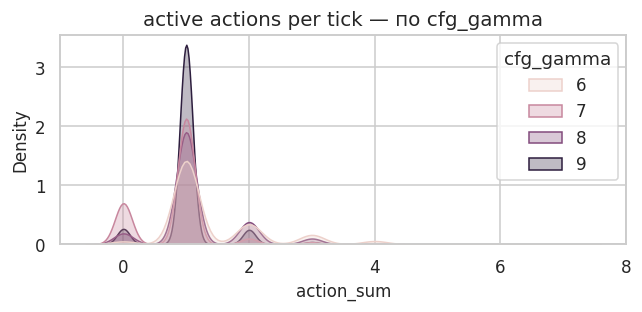

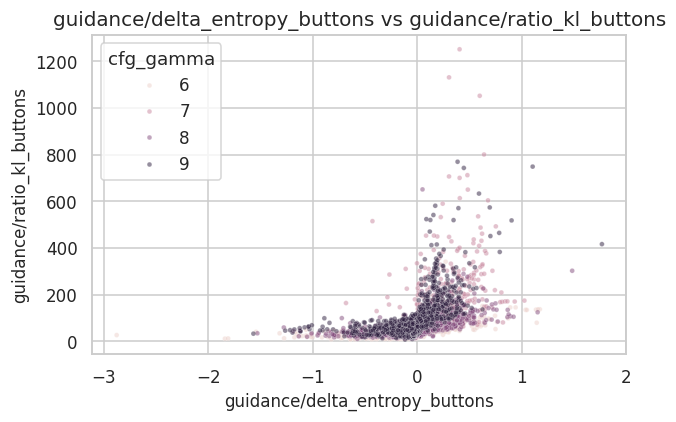

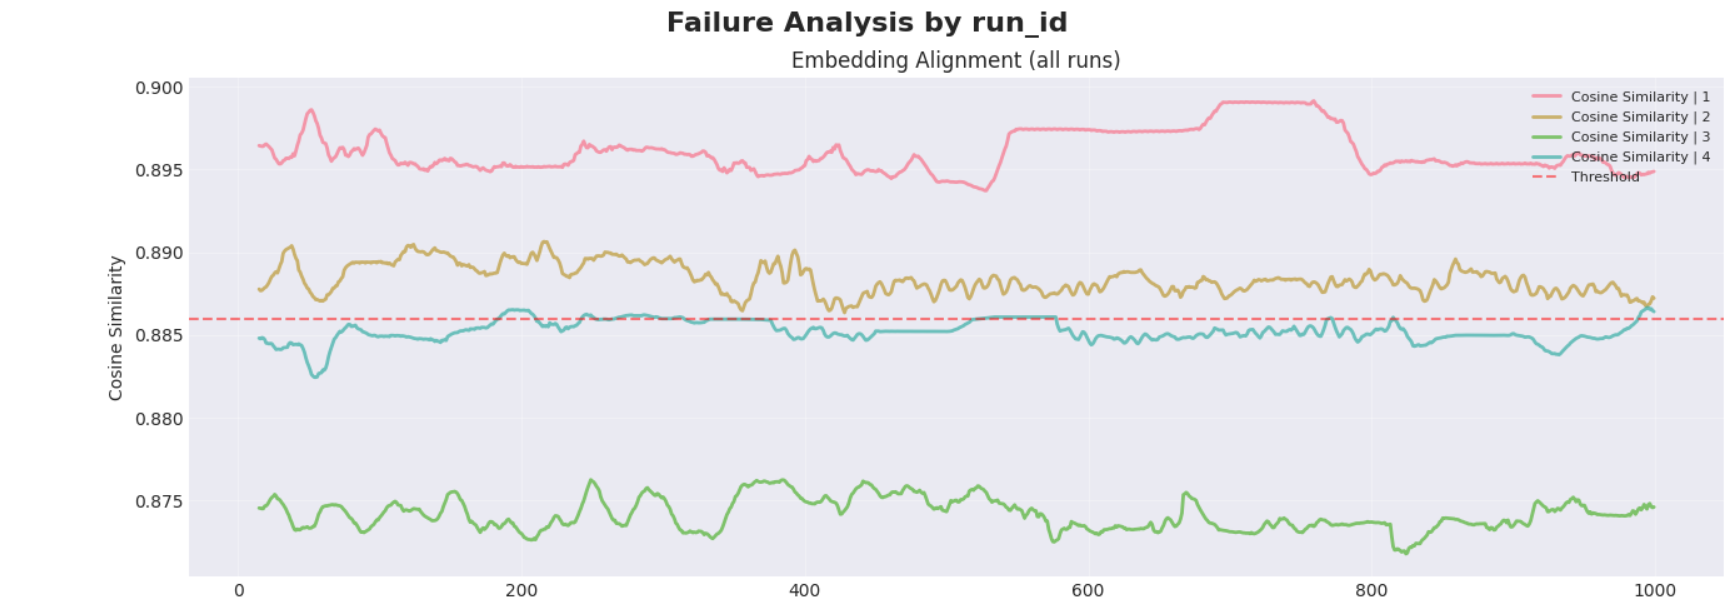

## Возможные планы на дальнейший анализ

Предлагается использовать самостоятельно собранный датасет формата видео-промпт задачи. Таким образом планируется дальнейший анализ MineCLIP и его метрик, которые могут влиять на качество входных данных для Policy, а также и Prior.

На данный момент датасет представляет из себя 17 видеороликов с сопровождающим файлом с промптами. Средняя длина ролика составляет 114 секунд. В видео представлены задачи, которые демонстрируют, как их выполняет человек, например, как добыть еду или докопаться до алмазов.

Также одним из пунктов для дальнейшей работы является анализ работы агента в контексте кластеризации его "намерений". Предлагается использовать датасет с возможными early-game задачами, как, например, скрафтить деревянную кирку. Все промпты необходимо будет перевести при помощи Prior в визуальные эмбеддинги и использовать один из алгоритмов кластеризации в латентном пространстве. В дальнейшем, чтобы оценить "намерение", или "представление" агента, будут использоваться последние его кадры для формирования визуального эмбеддинга и сопоставления его с кластерами, найденными ранее.

Сейчас имеется небольшой датасет с 1000 промптов, разделенными на группы. Каждая группа представляет из себя видоизмененные текстовые запросы одной и той же задачи.